# Clustering

In this assignment you will experiment with k-means as an image compression algorithm.


## Part 1: color image quantization

Color image quantization is the process of transforming an image so that it can be represented with a small subset of colors; a subset smaller than the image's original palette size. Image quantization is a form of lossy data compression since the number of bits used for the palette is reduced. During this compression some data is lost and therefore we must use a careful algorithm that will minimize the perceived difference between the original image and its quantized counterpart. Other than compression, image quantization plays an important role in image recognition algorithms.

When representing images in true color, each pixel is represented by 3 RGB components and each one of the 3 RGB components is represented by 8 bits and can take a value from 0 to 255. This means that in true color representation one can use 2^24≈16 Million different colors. In this exercise we will perform image quantization from images given in true color into 256, 16 or even less colors.

There are many algorithms for quantization. In this exercise, you are going to use K-means in color space to achieve quantization. The color (a point in RGB space) assigned to each pixel is the color of the centroid of the cluster. 

To summarize, every pixel in the image is a point in the three dimensional RGB space. We want to cluster these points into k clusters and then replace each pixel by the centroid of the cluster to which it was assigned to obtain the compressed image.

You might need to install skimage using `conda install -c conda-forge scikit-image`.

In [16]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


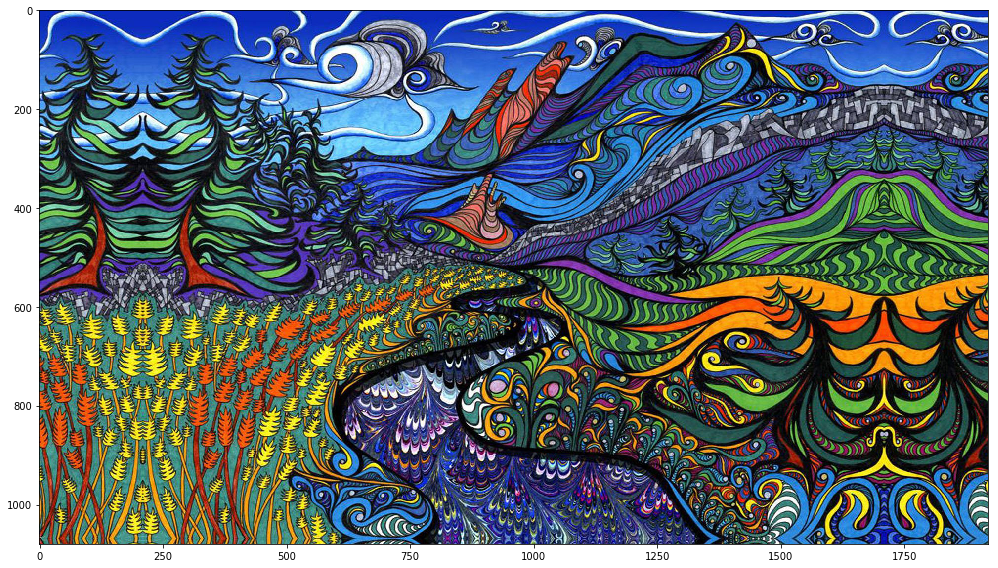

(1080, 1920, 3)


In [33]:
# load the image and confirm skimage is imported properly.
image = io.imread('data/scenic.jpg')
io.imshow(image)
io.show()
print(image.shape)

This single image has over 2 million values. Make sure your code is vectorized and efficient!

In [18]:
# save the dimensions of the image and reshape it for easier manipulation
rows = image.shape[0]
cols = image.shape[1]
image = image.reshape(image.shape[0]*image.shape[1],3)
print(image.shape)

(2073600, 3)


In [19]:
image

array([[ 13,  43, 189],
       [ 13,  43, 189],
       [ 13,  43, 189],
       ...,
       [ 66, 117, 110],
       [ 51, 107,  98],
       [ 31,  91,  83]], dtype=uint8)

## Random centroids

Each centroid is a point in RGB space (color) in the image. This function should uniformly pick `k` centroids from the dataset.

Input: a single image of shape `(num_instances, 3)` and `k`, the number of centroids. Notice we are flattening the image to a two dimentional array.
Output: Randomly chosen centroids of shape `(k,3)`.

In [20]:
def get_random_centroids(X, k):
    centroids = X[np.random.randint(len(X), size=k)]
    return centroids

In [21]:
k = 7 
centroids = get_random_centroids(image, k)
centroids

array([[  4,  26,  24],
       [ 72, 130,  79],
       [ 16,   3,   0],
       [ 47,  61,  62],
       [245,  91,  17],
       [115, 141, 156],
       [ 19,  18,  32]], dtype=uint8)

## Distance function

The Minkowski distance is a metric which can be considered as a generalization of the Euclidean and Manhattan distances. 

The Minkoski distance of order $p$ between two points: $\vec{x}=(x_1, ..., x_n)$ and $\vec{y}=(y_1, ..., y_n)$ is:
$$D(\vec{x},\vec{y}) = (\sum_{i=1}^n \mid x_i - y_i \mid ^p)^{\frac{1}{p}}$$

Implement the function `lp_distance` (=Minkowski distance).

Inputs: 
* a single image of shape `(num_instances, 3)` 
* the centroids `(k, 3)`
* the distance parameter p

output: array of shape `(k, num_instances)` thats holds the distances of all points in RGB space from all centroids

In [22]:
def lp_distance(X, centroids, p=2):
    distances = np.abs(X.astype(float) - centroids[:,np.newaxis,:]) ** p
    distances = distances.sum(axis=2)
    distances = distances ** (1 / p)
    
    return distances

In [24]:
distances = lp_distance(image, centroids, 5)
distances[:2]

array([[165.00039905, 165.00039905, 165.00039905, ..., 103.47185699,
         90.09198077,  71.65925908],
       [116.87137804, 116.87137804, 116.87137804, ...,  31.08166076,
         26.47070875,  46.00528964]])

## Kmeans algorithm

Calculate the locally optimal centroids as learned in class. At each iteration, assign every RGB point to the closest centroids and calculate new centroids by averaging the points that were assigned to every centroid. This function stops, 
when no improvement was made or once max_iter iterations passed.

A reasonable implementation runs on a Core i7 CPU in less than a minute with `k=16`.

In [30]:
def kmeans(X, k, p ,max_iter=100):
    """
    Inputs:
    - X: a single image of shape (num_features, 3).
    - k: number of centroids (i.e. colors).
    - p: the parameter governing the distance measure.
    - max_iter: the maximum number of iterations to perform.
    Outputs:
    - The calculated centroids
    - The final assignment of all RGB points to the closest centroids
    """
    classes = []
    centroids = get_random_centroids(X, k)

    for i in range(max_iter):
        print('iteration:', i+1)
        old_classes = classes.copy()
        
        distances = lp_distance(X, centroids, p)
        classes = np.argmin(distances, axis=0)
        
        if np.array_equal(old_classes, classes):
            print('done')
            return centroids, classes
        
        for j in range(k):
            centroids[j] = X[classes == j].mean(axis=0)
    
    return centroids, classes

In [29]:
centroids, classes = kmeans(image, k=4, p=1)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33


We obtained the locally optimal centroids (colors) from our image. To reconstruct the compressed image, we need to specify the color for each pixel that our algorithm associated with some centroid. The following cell does that for you.

In [31]:
def display_image(centroids, classes):
    classes = classes.reshape(rows,cols) 
    compressed_image = np.zeros((classes.shape[0],classes.shape[1],3),dtype=np.uint8 )
    for i in range(classes.shape[0]):
        for j in range(classes.shape[1]):
                compressed_image[i,j,:] = centroids[classes[i,j],:]
    io.imshow(compressed_image)
    io.show()

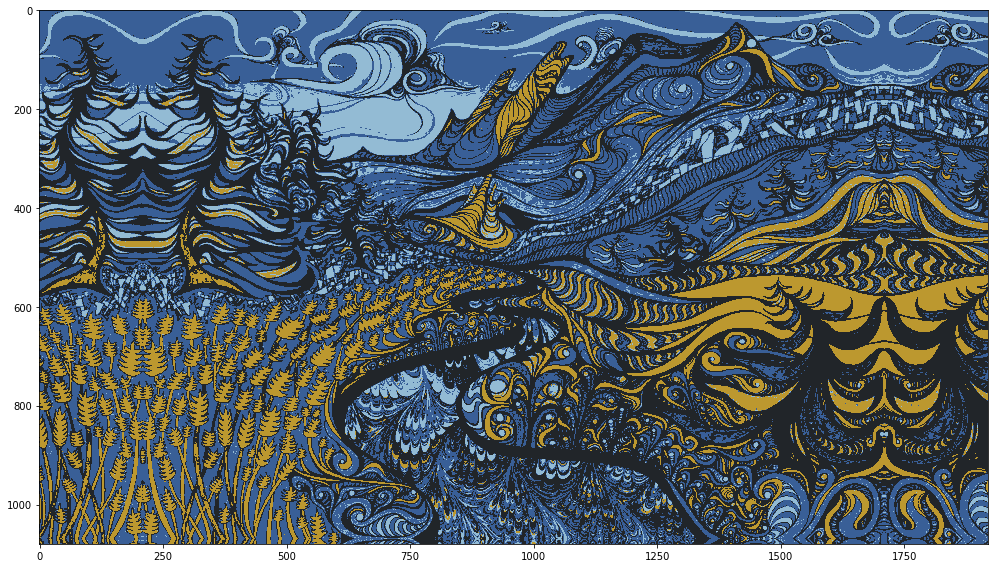

In [32]:
display_image(centroids, classes)

## Hyper parameter tuning

Pick 5 values for `p` and compare the results. Include both qualtitative and quantitivie analysis such as graphs, images and additional visualizations and explanations as you see fit.

P = 1


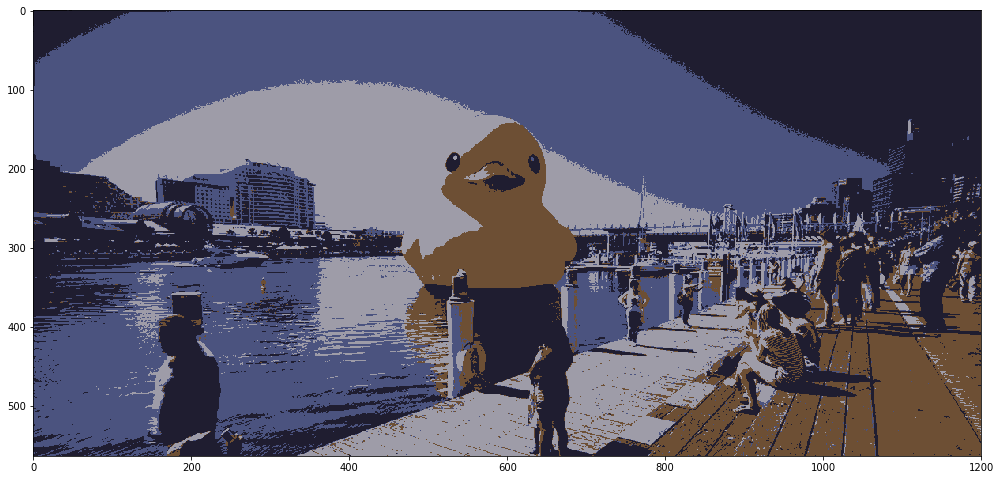

P = 2


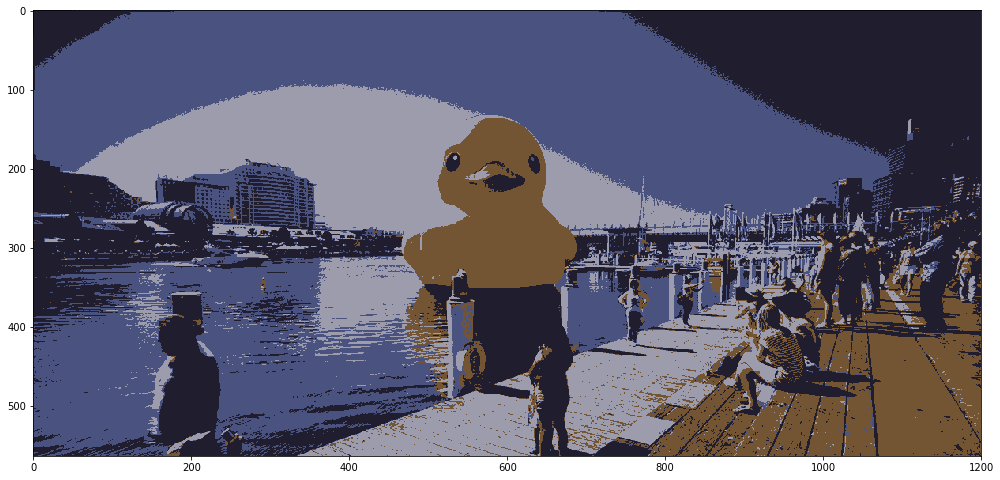

P = 3


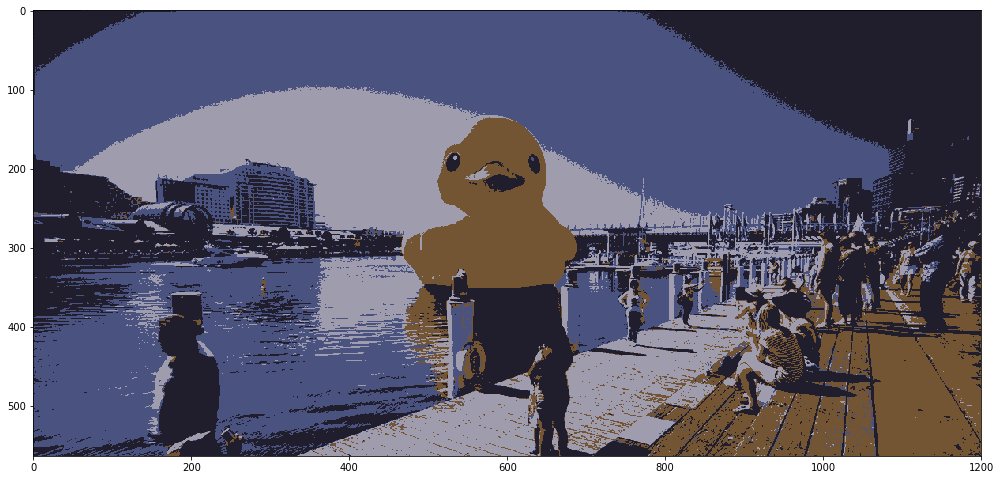

P = 4


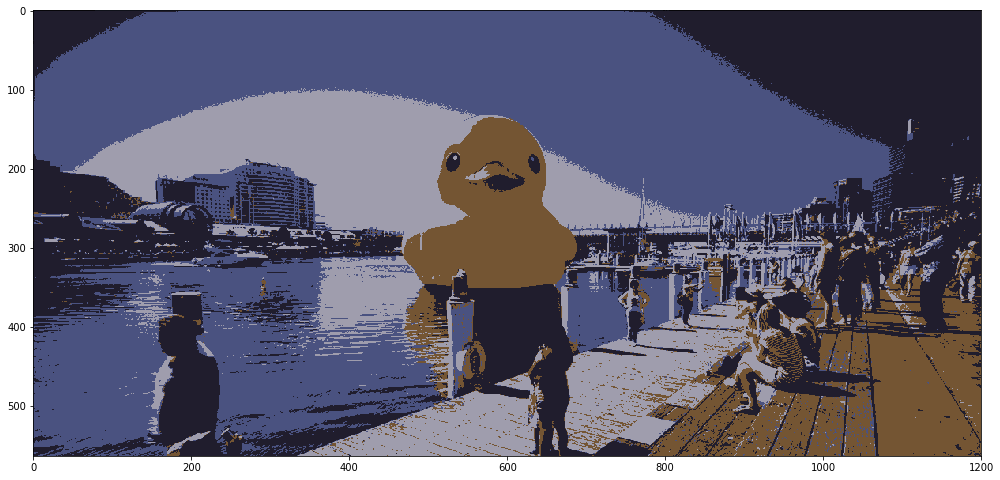

P = 5


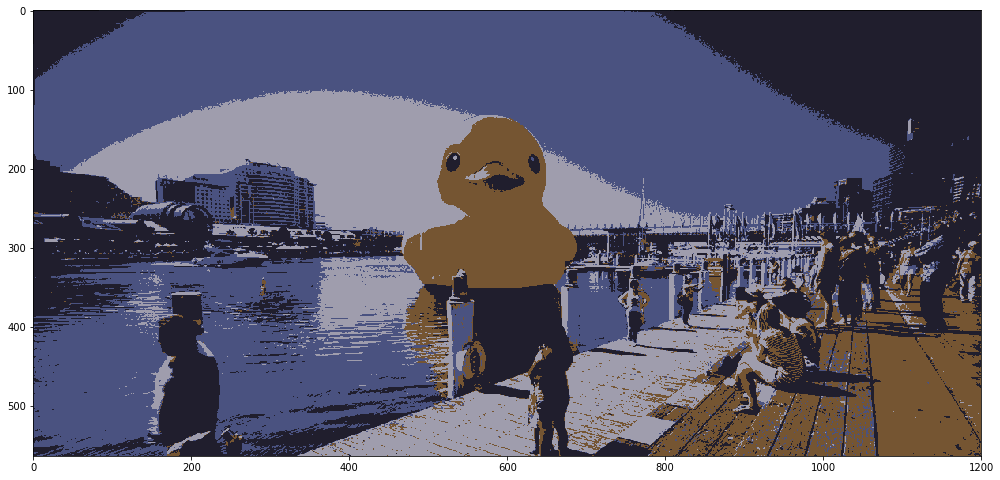

In [15]:
centroids = []
classes = []
for p in range(1, 6):
    cent, cl = kmeans(image, 4, p)
    print('p =', p)
    display_image(cent, cl)